In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import accuracy_score
from tensorflow.keras import regularizers

import time
import random
# import putemg_features
import tensorflow_addons as tfa

2022-12-20 23:08:12.680963: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 23:08:13.700227: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-20 23:08:13.700333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-20 23:08:13.700343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
label_types=["Apnea", "Normal"]

X = []
y = []

for label_in in range(len(label_types)):    
    path ="/home/cries/Workshop/Apnea/TrainData/"
    entries = os.listdir(path+label_types[label_in])
    
    # print(entries)

    for entry in entries:
        tmp = pd.read_csv(path+label_types[label_in]+"/"+entry, nrows = 6000)
        if len(tmp) > 0:
            X.append(tmp)
            y.append(label_in)

X_train = np.asarray(X)
y_train = np.asarray(y)  

In [3]:
label_types=["Apnea", "Normal"]

X = []
y = []

for label_in in range(len(label_types)):    
    path ="/home/cries/Workshop/Apnea/TestData/"
    entries = os.listdir(path+label_types[label_in])
    
    # print(entries)

    for entry in entries:
        tmp = pd.read_csv(path+label_types[label_in]+"/"+entry, nrows = 6000)
        if len(tmp) > 0:
            X.append(tmp)
            y.append(label_in)

X_test = np.asarray(X)
y_test = np.asarray(y)  

In [4]:
# minn=[]

# for i in range(len(X_train)):
#     minn.append(len(X_train[i]))

# np.max(minn)

In [5]:
#Import Package
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from keras.callbacks import ModelCheckpoint
from livelossplot import PlotLossesKeras

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')

with tf.device("gpu:0"):
   print("tf.keras code in this scope will run on GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]
tf.keras code in this scope will run on GPU


2022-12-20 23:08:15.983184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 23:08:16.535115: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9360 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:04:00.0, compute capability: 7.5


In [7]:
from sklearn.preprocessing import StandardScaler

scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = StandardScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [8]:
X_train.shape
X_test.shape

(66, 6000, 1, 1)

In [9]:
n_classes = len(np.unique(y))
print(n_classes)

def onehot(y):
    y = y.reshape(-1,1)

    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(handle_unknown='ignore')
    enc.fit(y)
    y = enc.transform(y).toarray()
    
    return y

y_train = onehot(y_train)
y_test = onehot(y_test)

2


In [10]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(66, 6000, 1, 1) (66, 6000, 1, 1) (66, 2) (66, 2)


In [11]:
num_class = np.unique(y_test)

In [19]:
inputs = keras.Input(shape=(X_train.shape[1:]))

x = inputs

# x = layers.Conv2D(12, 1)(x)
# x = layers.GlobalAveragePooling2D()(x)
x = layers.Conv2D(filters=3,kernel_size=(10,1))(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=3,kernel_size=(10,1))(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=3,kernel_size=(10,1))(x)
x = layers.LeakyReLU()(x)
x = layers.BatchNormalization()(x)
# x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)

x = layers.Dense(1000, activation='relu')(x)
x = layers.Dense(500, activation='relu')(x)
outputs = layers.Dense(n_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

In [ ]:
# model.summary()

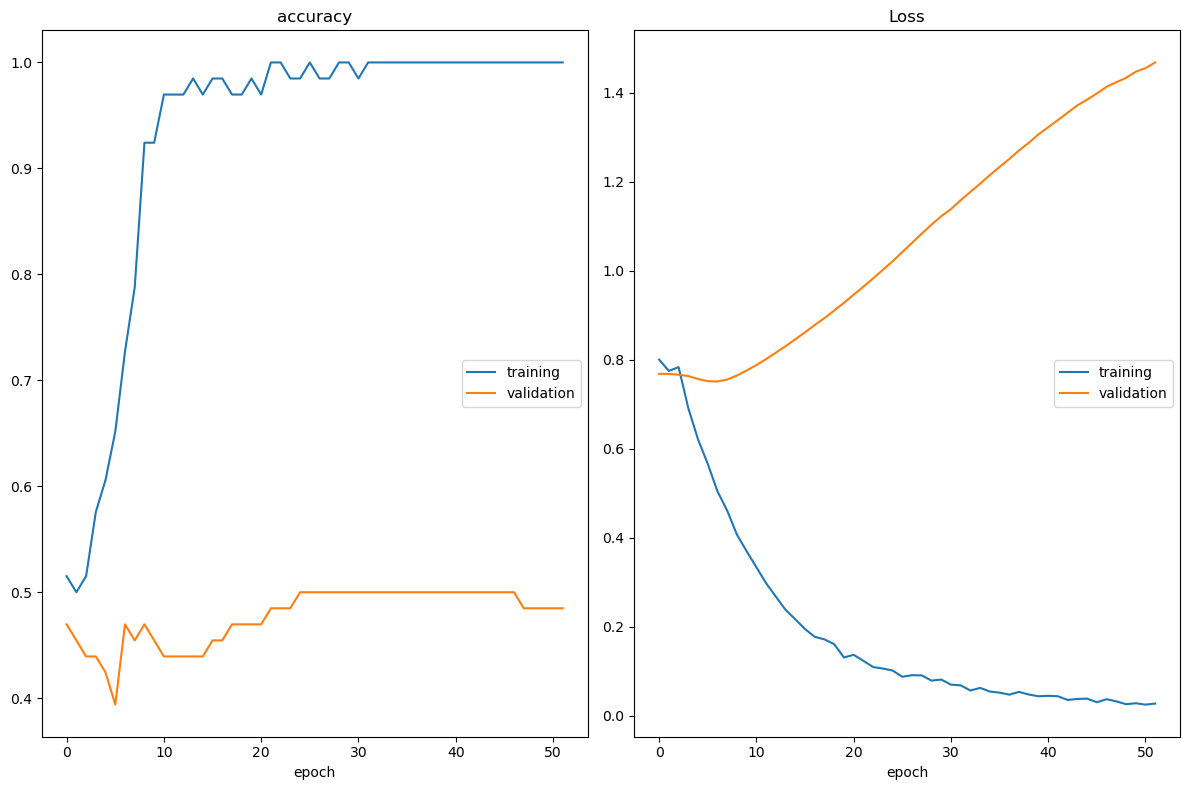

accuracy
	training         	 (min:    0.500, max:    1.000, cur:    1.000)
	validation       	 (min:    0.394, max:    0.500, cur:    0.485)
Loss
	training         	 (min:    0.025, max:    0.800, cur:    0.027)
	validation       	 (min:    0.751, max:    1.468, cur:    1.468)
5/5 [==============================] - 0s 101ms/step - loss: 0.0273 - accuracy: 1.0000 - val_loss: 1.4678 - val_accuracy: 0.4848


KeyboardInterrupt: 

In [20]:
epoch = 5000

lr = 0.00001
decay_rate = lr / epoch
momentum = 0.99
sgd = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum, weight_decay=decay_rate, nesterov=False)
checkpoint = ModelCheckpoint('model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto', period=1)

optimizer = sgd
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
history = model.fit(X_train, y_train,  batch_size=16, epochs=epoch, validation_data=(X_test, y_test),callbacks=[checkpoint,PlotLossesKeras()],verbose=1)